In [23]:
!pip install seaborn tensorflow scikit-learn pandas matplotlib numpy


In [24]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías de Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Configuración de gráficos
plt.style.use('ggplot')

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.20.0


In [25]:

RUTA_METADATA = "C:/Users/svndo/ACUS220_Audio_DeepLearning/data/processed/tiny_specs/metadata.csv"
CARACTERISTICA_A_USAR = 'mel_db' 

# 1. Cargar CSV
if os.path.exists(RUTA_METADATA):
    df = pd.read_csv(RUTA_METADATA)
    print(f" Metadata cargada. Total de muestras: {len(df)}")
else:
    # Intentar ruta relativa por si acaso
    RUTA_ALTERNATIVA = "data/processed/tiny_specs/metadata.csv"
    if os.path.exists(RUTA_ALTERNATIVA):
        df = pd.read_csv(RUTA_ALTERNATIVA)
        print(f" Metadata cargada (ruta relativa). Total: {len(df)}")
    else:
        print(" No se encontró el archivo metadata.csv")
        df = pd.DataFrame() # DataFrame vacío para evitar errores posteriores

# 2. Función para cargar los arrays .npz
def cargar_features(df, key_name='mel_db'):
    X = []
    y = []
    print("Cargando archivos .npz...")
    
    for index, row in df.iterrows():
        ruta_npz = row['npz']
        # Corrección de ruta si es relativa
        if not os.path.exists(ruta_npz):
             ruta_posible = os.path.join("C:/Users/svndo/ACUS220_Audio_DeepLearning", ruta_npz)
             if os.path.exists(ruta_posible):
                 ruta_npz = ruta_posible
        
        if os.path.exists(ruta_npz):
            try:
                data = np.load(ruta_npz)
                if key_name in data:
                    X.append(data[key_name])
                    y.append(row['label'])
            except Exception as e:
                print(f"Error en {ruta_npz}: {e}")
    return np.array(X), np.array(y)

# Ejecutar carga
if not df.empty:
    X_raw, y_raw = cargar_features(df, key_name=CARACTERISTICA_A_USAR)
    # Ajustar dimensión para la red neuronal (Alto, Ancho, 1 canal)
    if len(X_raw.shape) == 3:
        X_data = X_raw[..., np.newaxis]
        print(f"Dimensiones listas para CNN: {X_data.shape}")
    else:
        print(" Revisa las dimensiones de los datos cargados.")

 Metadata cargada. Total de muestras: 1221
Cargando archivos .npz...
Dimensiones listas para CNN: (1221, 64, 173, 1)


In [29]:
if 'X_train' in locals():
    input_shape = X_train.shape[1:] # Toma el tamaño de tus imágenes (Alto, Ancho, 1)

    model = Sequential([
        # Capa 1
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        
        # Capa 2
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        
        # Capa 3
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.3), # Apaga neuronas al azar para evitar memorizar
        
        # Aplanar y Clasificar
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax') # Salida final
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

C:\Users\svndo\miniconda3\envs\acus_python\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 64, 173, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 32, 86, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32, 86, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 86, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 16, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 16, 43, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 43, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 8, 21, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 8, 21, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 21504)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       2,752,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,846,341 (10.86 MB)

 Trainable params: 2,846,149 (10.86 MB)

 Non-trainable params: 192 (768.00 B)

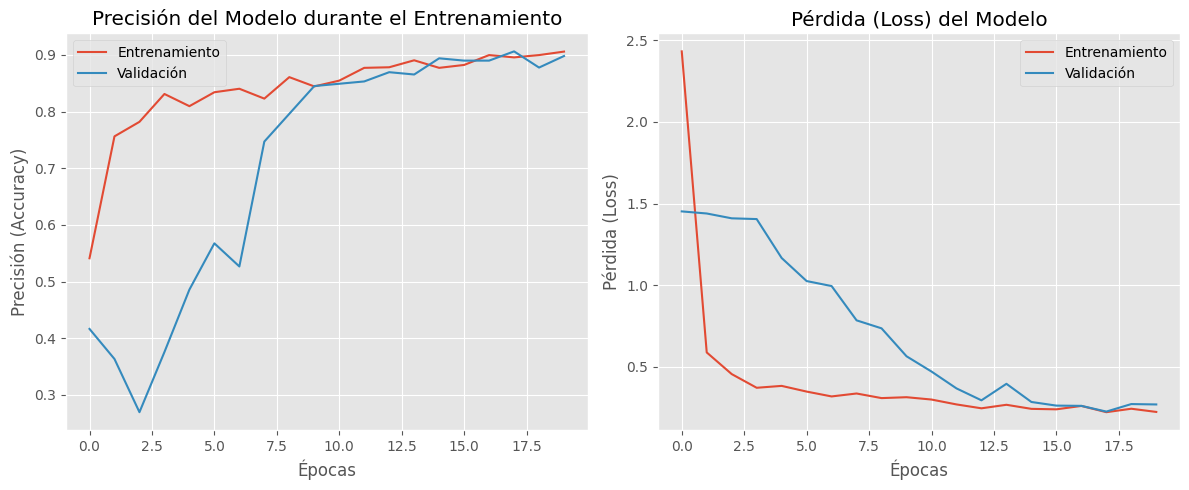

In [30]:
if 'history' in locals():
    # Gráfico de Precisión y Pérdida
    plt.figure(figsize=(12, 5))

    # Subgráfico 1: Precisión (Accuracy)
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Validación')
    plt.title('Precisión del Modelo durante el Entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión (Accuracy)')
    plt.legend()
    plt.grid(True) # Añade una cuadrícula para mejor lectura

    # Subgráfico 2: Pérdida (Loss)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Entrenamiento')
    plt.plot(history.history['val_loss'], label='Validación')
    plt.title('Pérdida (Loss) del Modelo')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida (Loss)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout() # Ajusta los espacios para que no se solapen
    plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


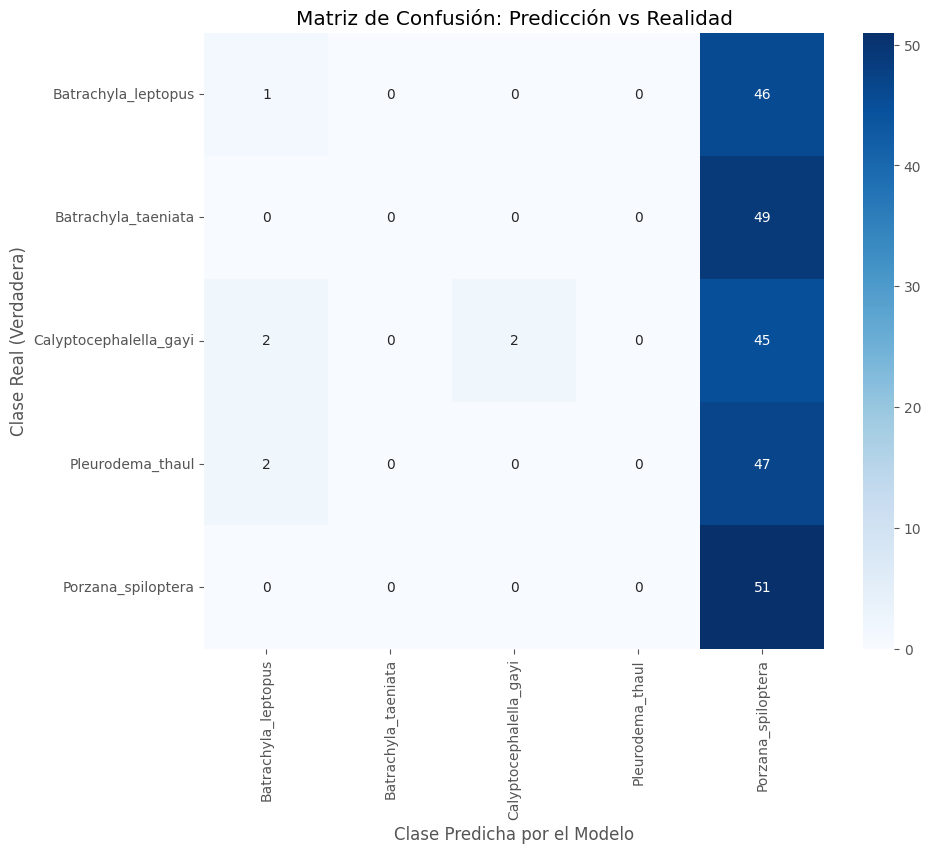


REPORTE DE CLASIFICACIÓN (Métricas por Especie)
Especie (Clase)                Precisión  Recall     F1-Score   Soporte   
---------------------------------------------------------------------------
Batrachyla_leptopus            0.20       0.02       0.04       47.0      
Batrachyla_taeniata            0.00       0.00       0.00       49.0      
Calyptocephalella_gayi         1.00       0.04       0.08       49.0      
Pleurodema_thaul               0.00       0.00       0.00       49.0      
Porzana_spiloptera             0.21       1.00       0.35       51.0      
---------------------------------------------------------------------------
Exactitud Global (Accuracy)    0.22


C:\Users\svndo\miniconda3\envs\acus_python\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\svndo\miniconda3\envs\acus_python\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\svndo\miniconda3\envs\acus_python\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

In [31]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

if 'model' in locals() and 'X_test' in locals():
    # 1. Obtener predicciones
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # 2. Generar Matriz de Confusión
    cm = confusion_matrix(y_true, y_pred)
    
    # Graficar la Matriz
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=encoder.classes_, 
                yticklabels=encoder.classes_)
    plt.title('Matriz de Confusión: Predicción vs Realidad')
    plt.xlabel('Clase Predicha por el Modelo')
    plt.ylabel('Clase Real (Verdadera)')
    plt.show()

    # 3. Reporte de Clasificación (Traducido manualmente para visualización)
    print("\n" + "="*60)
    print("REPORTE DE CLASIFICACIÓN (Métricas por Especie)")
    print("="*60)
    
    # Obtenemos el reporte como diccionario para poder formatearlo nosotros
    report = classification_report(y_true, y_pred, target_names=encoder.classes_, output_dict=True)
    
    # Imprimir cabecera
    print(f"{'Especie (Clase)':<30} {'Precisión':<10} {'Recall':<10} {'F1-Score':<10} {'Soporte':<10}")
    print("-" * 75)
    
    # Imprimir cada clase
    for clase in encoder.classes_:
        metrics = report[clase]
        print(f"{clase:<30} {metrics['precision']:.2f}       {metrics['recall']:.2f}       {metrics['f1-score']:.2f}       {metrics['support']:<10}")
    
    print("-" * 75)
    # Métricas globales
    print(f"{'Exactitud Global (Accuracy)':<30} {report['accuracy']:.2f}")
    print("="*60)